In [1]:
from numpy import mean, std
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD

from PIL import Image

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(f'X train type and shape: {type(X_train)}, {X_train.shape}')
print(f'y train type and shape: {type(y_train)}, {y_train.shape}')
print(f'X test type and shape: {type(X_test)}, {X_test.shape}')
print(f'y test type and shape: {type(y_test)}, {y_test.shape}')

X train type and shape: <class 'numpy.ndarray'>, (60000, 28, 28)
y train type and shape: <class 'numpy.ndarray'>, (60000,)
X test type and shape: <class 'numpy.ndarray'>, (10000, 28, 28)
y test type and shape: <class 'numpy.ndarray'>, (10000,)


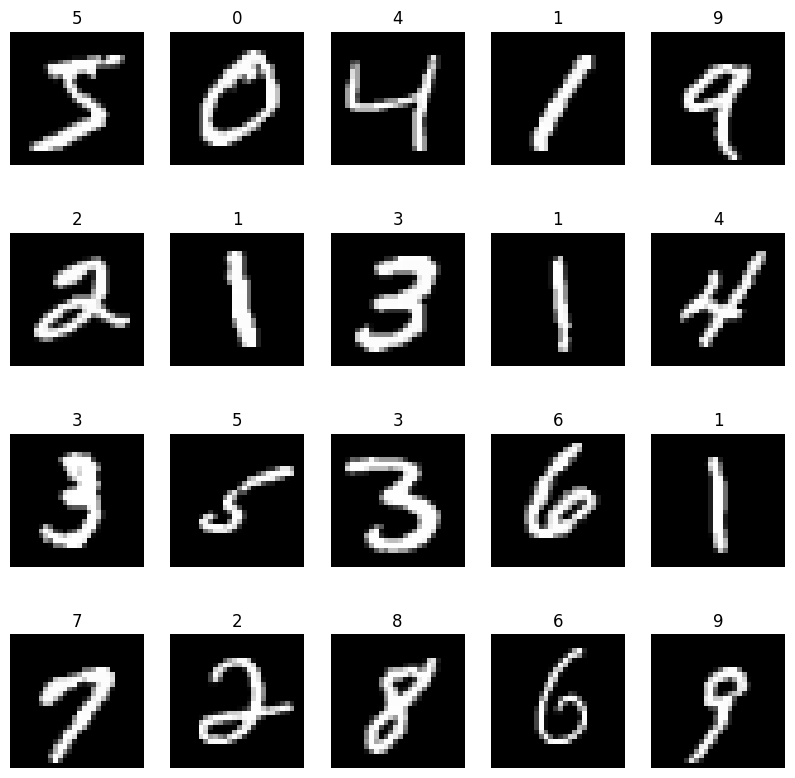

In [4]:
plt.figure(figsize = (10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.title(y_train[i])
    plt.imshow(X_train[i], cmap = plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
type(y_train[4])

numpy.uint8

In [7]:
def resize_images(images, size):
    resized_images = []
    for img in images:
        img_resized = tf.image.resize(img, size)
        resized_images.append(img_resized)
    return np.array(resized_images)

In [8]:
def load_dataset():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    #Cannot reshape the images to 227 * 227
    # train_X = X_train.reshape((X_train.shape[0], 227, 227, 1))
    # test_X = X_test.reshape((X_test.shape[0], 227, 227, 1))
    #Let's try reshaping the images
    train_X = tf.expand_dims(X_train, axis = -1)
    test_X = tf.expand_dims(X_test, axis = -1)
    #and then reshape the images
    train_X = resize_images(train_X,[227, 227])
    test_X = resize_images(test_X,[227, 227])

    train_y = to_categorical(y_train)
    test_y = to_categorical(y_test)
    return train_X, train_y, test_X, test_y

In [9]:
def prep_pixels(train, test):
    # train_norm = train.astype('float32')
    # test_norm = test.astype('float32')

    # train_norm = tf.cast(train, tf.float32) / 255.0
    # test_norm = tf.cast(test, tf.float32) / 255.0

    train_norm = train / 255.0
    test_norm = test / 255.0

    return train_norm, test_norm

In [10]:
def model_alex_net():
    model = Sequential()
    model.add(Conv2D(filters = 96, kernel_size = (11, 11), strides = (4, 4), activation = 'relu', input_shape = (227, 227, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

    model.add(Conv2D(filters = 256, kernel_size = (5, 5), strides = (1, 1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

    model.add(Conv2D(filters = 384, kernel_size = (13, 13), strides = (1, 1), padding = 'same'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters = 384, kernel_size = (13, 13), strides = (1, 1), padding = 'same'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters = 256, kernel_size = (13, 13), strides = (1, 1), padding = 'same'))
    model.add(BatchNormalization())

    model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Dropout(0.5))
    # model.add(Dense(4096))
    model.add(Dense(10, activation = 'softmax'))
    opt = SGD(learning_rate = 0.001)
    model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [11]:
def evaluate_model(data_X, data_Y, n_folds = 5):
    scores, histories = list(), list()
    kfold = KFold(n_folds, shuffle = True, random_state = 1)
    for train_ix, test_ix in kfold.split(data_X):
        alex_net = model_alex_net()
        trainX, trainY, testX, testY = data_X[train_ix], data_Y[train_ix], data_X[test_ix], data_Y[test_ix]

        history = alex_net.fit(trainX, trainY, epochs = 10, batch_size = 32, validation_data = (testX, testY), verbose = 0)

        _, acc = alex_net.evaluate(testX, testY)
        print(f'Accuracy: {acc * 100}')
        scores.append(acc)
        histories.append(history)
    alex_net.save('model_alex_net.h5')
    return scores, histories

In [12]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        plt.subplot(2, 1, 1)
        plt.title("Sparse Categorical Cross Entropy Loss")
        plt.plot(histories[i].history['loss'], color = 'blue', label = 'train')
        plt.plot(histories[i].history['val_loss'], color = 'orange', label = 'test')

        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color = 'blue', label = 'train')
        plt.plot(histories[i].history['val_accuracy'], color = 'orange', label = 'test')
    plt.show()

In [13]:
def summarize_performance(scores):
    print(f'Accuracy: mean = {mean(scores) * 100}, std = {std(scores) * 100}, n = {len(scores)}')
    plt.boxplot(scores)
    plt.show()

In [14]:
def run_test_harness():
    trainX, tainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    scores, histories = evaluate_model(trainX, tainY)
    summarize_diagnostics(histories)
    summarize_performance(scores)

In [ ]:
run_test_harness()